In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import IPython
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import torch
import scipy
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from flowability_data_upload.Research.main import Data

# Preprocessing

In [3]:
%%capture

def load_data():
    x = Data()
    x.importnewpowders()
    df_data = pd.DataFrame(x.data)
    df_flow = pd.DataFrame(x.flow)
    df_noflow = pd.DataFrame(x.noflow)

    return df_data, df_flow, df_noflow

df_data, df_flow, df_noflow = load_data()

df_all = df_data.copy()

pd.set_option('display.max_columns', None)

flow = df_data.pop("Flow")
powder = df_data.pop("Powder")
flow_class = df_data.pop("Flow Class")
features = df_data

# Feature Distribution Plots

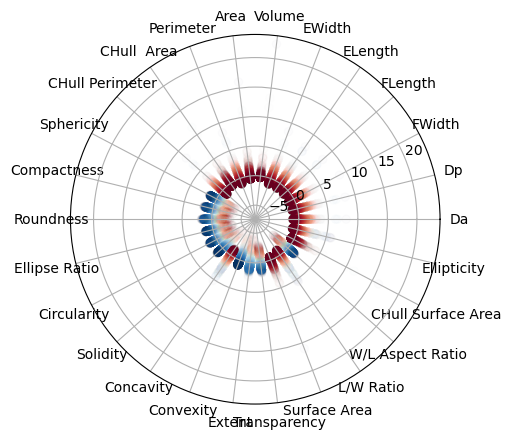

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def plot(df):

    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    df_scaled.pop('Curvature')

    num_cols = len(df_scaled.columns)

    # create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')

    # plot each element in each column
    for i in range(num_cols):
        # compute the angle for each element
        angles = 2* np.pi * i * np.ones(df_scaled.shape[0]) / num_cols

        # plot the elements as points on the polar plot
        ax.scatter(angles, df_scaled.iloc[:, i], c=df_scaled.iloc[:, i], cmap="RdBu", alpha=0.01)
    ax.set_thetagrids(np.arange(0, 360, 360/num_cols), labels=df_scaled.columns)
    # show the plot
    plt.show()

plot(features.sample(1000))

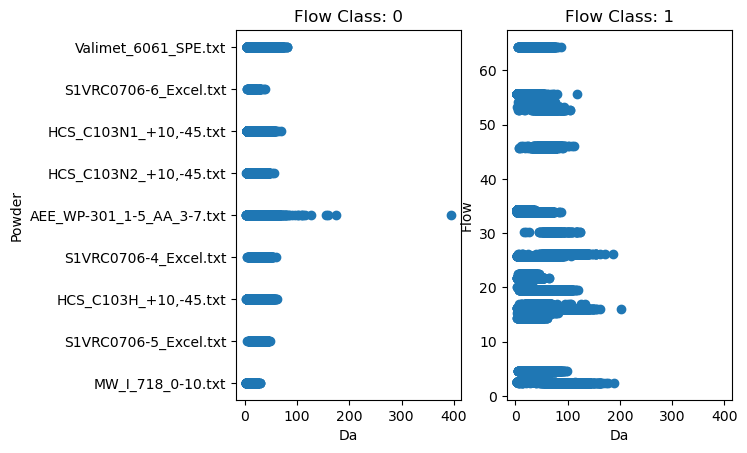

In [4]:
def compare_flow(x = 'Da'):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex = True)


    # Iterate over the groups in the groupby
    for name, group in df_all.groupby('Flow Class'):
        # Check if there are any samples with non-zero 'Flow'
        if any(group['Flow']):
            # Plot the 'Flow' vs 'Da' data in the second subplot
            axes[1].scatter(group[x], group['Flow'])
            axes[1].set_title('Flow Class: {}'.format(name))
            axes[1].set_xlabel(x)
            axes[1].set_ylabel('Flow')
            #axes[1].legend(loc = 'upper right')
        else:
            # Plot the 'Flow' vs 'Da' data in the first subplot
            axes[0].scatter(group[x], group['Powder'])
            axes[0].set_title('Flow Class: {}'.format(name))
            axes[0].set_xlabel(x)
            axes[0].set_ylabel('Powder')

    plt.show()

compare_flow()

# Particle similarity matrix/graph

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def resample(df_data, target = "Powder", n = 10000):
    grouped_df = df_data.groupby('Powder')
    # create a new dataframe to hold the resampled rows
    resampled_df = pd.DataFrame()

    # for each group in the grouped dataframe
    for name, group in grouped_df:
        # if the number of rows in the group is greater than n
        if len(group) > n:
            # undersample the group without replacement
            resampled_group = group.sample(n=n, replace=False)
        else:
            # oversample the group with replacement
            resampled_group = group.sample(n=n, replace=True)
        # append the resampled group to the resampled dataframe
        resampled_df = pd.concat([resampled_df, resampled_group], axis = 0)

    # print the resampled dataframe
    resampled_df = resampled_df.reset_index(drop = True)

    return resampled_df

diag = []

data = df_all.copy().reset_index(drop=True)
data = resample(data, n = 100)
flow_class = data.pop('Flow Class')
flow = data.pop('Flow')
powder = data.pop('Powder')

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
          

In [327]:
#THIS BLOCK WILL TAKE FOREVER

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

X = data.values

mat = cosine_similarity(X[:1])

for i in range(1,len(X)):
    
    col = cosine_similarity(X[:i], X[i].reshape(1,-1))

    def stack(mat, col):
        #assumes col is of shape nrow x 1
        mat2 = np.hstack((mat, col))
        mat3 = np.vstack((mat2, np.append(col, [1.])))

        return mat3

    mat = stack(mat, col)

mat

array([[ 1.   ,  0.966,  0.573, ...,  0.441,  0.187, -0.008],
       [ 0.966,  1.   ,  0.434, ...,  0.308, -0.022, -0.187],
       [ 0.573,  0.434,  1.   , ...,  0.561,  0.749,  0.452],
       ...,
       [ 0.441,  0.308,  0.561, ...,  1.   ,  0.556,  0.539],
       [ 0.187, -0.022,  0.749, ...,  0.556,  1.   ,  0.797],
       [-0.008, -0.187,  0.452, ...,  0.539,  0.797,  1.   ]])

In [140]:
particles = data.sample(50).values

f = open('particle_distances.txt','w')
f.truncate()
for i in range(0, len(particles)):
  for j in range(i, len(particles)):
    f.write('%s,%s,%1.6f\n' %
        (particles[i], particles[j],
        1 - cosine_similarity(particles[i].reshape(1,-1), particles[j].reshape(1,-1))))
f.flush()
f.close()

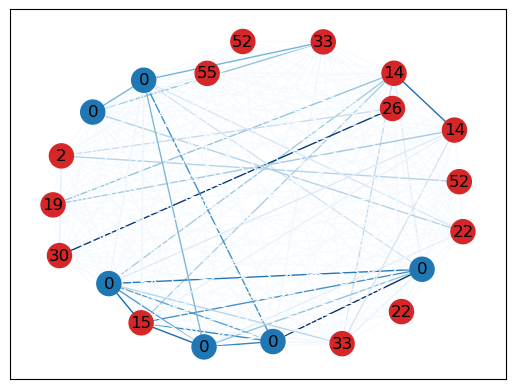

In [229]:
import networkx as nx

X = data.sample(20)
labels = flow.iloc[X.index].astype(np.int8).reset_index(drop = True).to_dict()
adj = pd.DataFrame(1 - cosine_similarity(X.values)).apply(lambda x: 1000**x - 1).astype(np.float16)
G = nx.from_pandas_adjacency(adj)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(adj)
edge_colors = np.apply_along_axis(lambda x:np.exp(-1*x), 0, weights)
nx.draw_networkx_nodes(G ,pos=pos, node_color = ["tab:red" if f > 0 else "tab:blue" for f in labels.values()])
nx.draw_networkx_edges(G ,pos=pos, edge_color=edge_colors, edge_cmap=plt.cm.Blues)
a = nx.draw_networkx_labels(G, pos = pos, labels = labels)

# Graph Neural Network

In [153]:
df = df_all.copy().reset_index(drop=True)
df["Flow"].apply(lambda x: np.reciprocal(x) if x else x).unique()

array([0.05 , 0.046, 0.039, 0.029, 0.029, 0.038, 0.   , 0.019, 0.42 ,
       0.033, 0.062, 0.062, 0.065, 0.016, 0.069, 0.392, 0.044, 0.059,
       0.019, 0.018, 0.051, 0.22 , 0.022, 0.022, 0.018])

In [40]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

flow_bins = [0, 4, 16, 24, 32, 40, 54]
flow_bins = [0, 0.01, 0.02, 0.035, 0.05, 0.1, 0.4, 1]
closest = lambda x: min(flow_bins, key=lambda y: abs(x-y))

N = 5000

def resample(df_data, target = "Powder", n = 10000):
    grouped_df = df_data.groupby(target)
    resampled_df = pd.DataFrame()
    for name, group in grouped_df:
        if len(group) > n:
            resampled_group = group.sample(n=n, replace=False)
        else:
            resampled_group = group.sample(n=n, replace=True)
        resampled_df = pd.concat([resampled_df, resampled_group], axis = 0)
    resampled_df = resampled_df.reset_index(drop = True)
    return resampled_df

data = df_all.copy().reset_index(drop=True)
#data["Flow"] = data["Flow"].apply(lambda x: np.reciprocal(x) if x else x)
#data['Flow'] = data['Flow'].apply(closest)
#data['Flow'] = LabelEncoder().fit_transform(data["Flow"])
data = resample(data, n = N, target="Powder")
data = resample(data, n = int(N/2), target="Flow Class")
flow_class = data.pop('Flow Class')
data.pop("Powder")
flow = data.pop("Flow")
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data["Flow Class"] = flow_class

train_data, test_data = [], []

for _, group_data in data.groupby("Flow Class"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2456, 28)
Test data shape: (2544, 28)


In [46]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 16

In [41]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [42]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

## FFN Baseline

In [16]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [43]:
feature_names = set(data.columns) - {"Flow Class"}
num_features = len(feature_names)
num_classes = 2

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Flow Class"]
y_test = test_data["Flow Class"]

/var/folders/qm/3gmtl0v9389290bhcns4s42m0000gq/T/ipykernel_53061/2802685010.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
/var/folders/qm/3gmtl0v9389290bhcns4s42m0000gq/T/ipykernel_53061/2802685010.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


In [44]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 27)]         0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           2188        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [45]:
history = run_experiment(baseline_model, x_train, y_train)
IPython.display.clear_output()

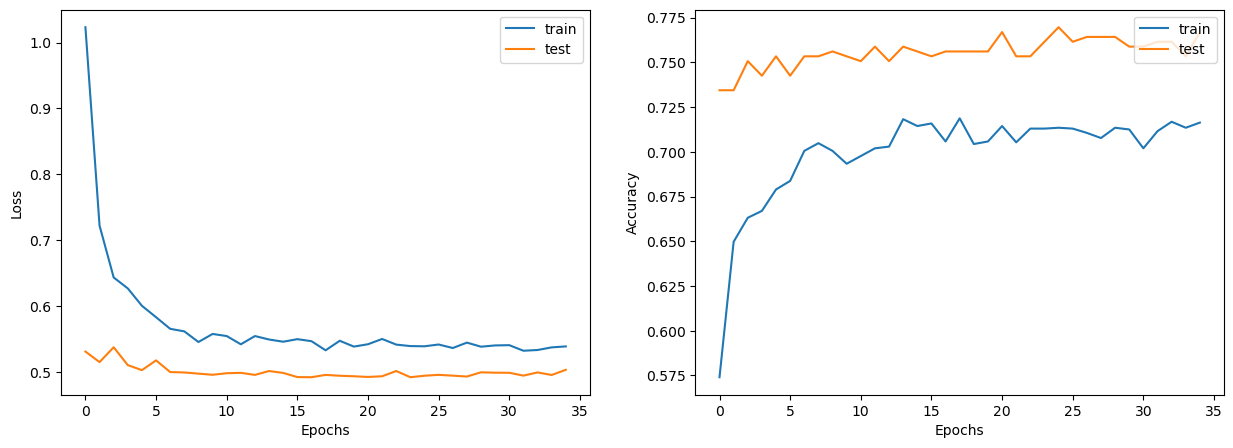

In [47]:
display_learning_curves(history)

In [48]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.38%


## Creating the Graph

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

particles = data.copy().drop(["Flow Class"], axis = 1).to_numpy()
#random connections
edges = np.random.randint(0, len(particles), size=(2, 50000))
edge_weights = np.squeeze([1 - cosine_similarity(particles[i].reshape(1,-1), particles[j].reshape(1,-1)) for i,j in zip(edges[0],edges[1])])
node_features = tf.cast(data.sort_index()[feature_names].to_numpy(), dtype=tf.dtypes.float32)
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 50000)
Nodes shape: (5000, 27)


/var/folders/qm/3gmtl0v9389290bhcns4s42m0000gq/T/ipykernel_53061/3164315835.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  node_features = tf.cast(data.sort_index()[feature_names].to_numpy(), dtype=tf.dtypes.float32)


## Graph Conv

In [50]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        properties = self.ffn_prepare(node_repesentations)
        if weights is not None:
            properties = properties * tf.expand_dims(weights, -1)
        return properties

    def aggregate(self, node_indices, neighbour_properties, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_properties shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_properties, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_properties, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_properties, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_properties):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_properties shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_properties], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_properties.
            h = tf.concat([node_repesentations, aggregated_properties], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_properties.
            h = node_repesentations + aggregated_properties
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the properties of the neighbours.
        neighbour_properties = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour properties.
        aggregated_properties = self.aggregate(
            node_indices, neighbour_properties, node_repesentations
        )
        # Update the node embedding with the neighbour properties.
        return self.update(node_repesentations, aggregated_properties)

In [51]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [59]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    aggregation_type="max",
    combination_type="gru",
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.076 -0.278]
 [-0.02  -0.194]
 [-0.126 -0.133]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (5000, 32)                2188      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 4736      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 4736      
 )                                                               
                                                                 
 postprocess (Sequential)    (5000, 32)                2368      
                                                                 
 logits (Dense)              multiple                  66        
            

In [60]:
x_train = train_data.index.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/100


/Users/aidan.horn/opt/anaconda3/envs/VAE/lib/python3.10/site-packages/keras/engine/data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


131/131 [==============================] - 15s 92ms/step - loss: 0.6791 - acc: 0.6071 - val_loss: 0.5069 - val_acc: 0.7588
Epoch 2/100
131/131 [==============================] - 11s 84ms/step - loss: 0.5758 - acc: 0.6977 - val_loss: 0.5049 - val_acc: 0.7561
Epoch 3/100
131/131 [==============================] - 11s 84ms/step - loss: 0.5791 - acc: 0.7034 - val_loss: 0.5052 - val_acc: 0.7615
Epoch 4/100
131/131 [==============================] - 11s 86ms/step - loss: 0.5642 - acc: 0.7106 - val_loss: 0.5180 - val_acc: 0.7561
Epoch 5/100
131/131 [==============================] - 11s 84ms/step - loss: 0.5579 - acc: 0.7034 - val_loss: 0.4966 - val_acc: 0.7534
Epoch 6/100
131/131 [==============================] - 11s 82ms/step - loss: 0.5521 - acc: 0.7053 - val_loss: 0.4981 - val_acc: 0.7507
Epoch 7/100
131/131 [==============================] - 11s 84ms/step - loss: 0.5528 - acc: 0.7053 - val_loss: 0.4963 - val_acc: 0.7534
Epoch 8/100
131/131 [==============================] - 11s 84ms/ste

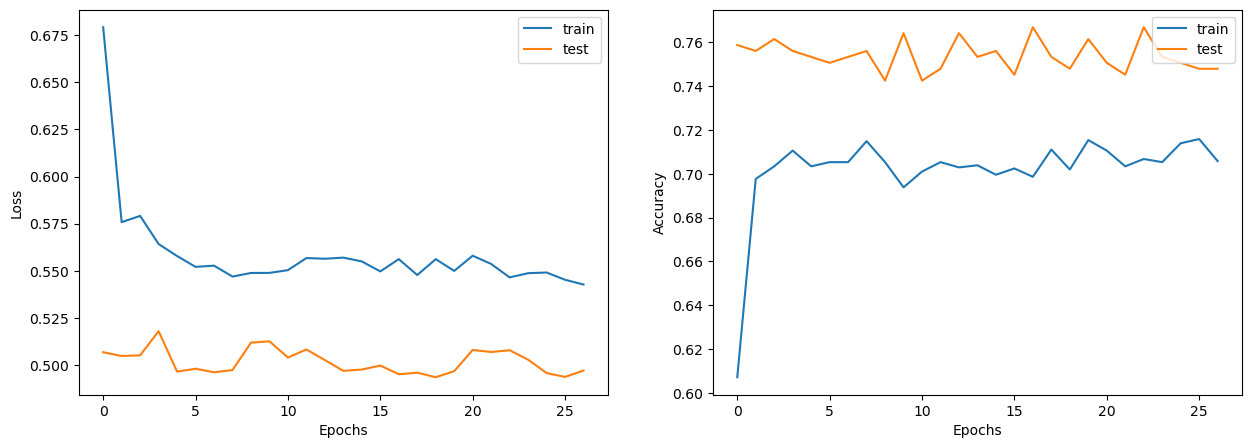

In [61]:
display_learning_curves(history)

In [41]:
from scipy.special import softmax

def compare():
    df = df_all.copy().reset_index(drop=True)
    for p in powder.unique():
        df_ = df[df['Powder'] == p]
        df_ = resample(df_, target="Powder", n=1000)
        df_.pop('Flow Class')
        df_.pop('Powder')
        fl = df_.pop('Flow').apply(lambda x: np.reciprocal(x) if x else x)
        df_ = pd.DataFrame(scaler.transform(df_), columns=df_.columns)
        preds = baseline_model.predict(df_)
        guesses = []
        for pred in preds:
            sf = softmax(pred)
            c = np.argmax(sf)
            guesses.append(flow_bins[c])
            mode,count = scipy.stats.mode(guesses)
        m = np.mean(guesses)
        print(f"Powder: {p} | Actual Flow: {fl.iloc[0]:.3f} | Mean Predicted Flow: {m:.3f} | Mode: {mode[0]} | Count {count[0]}/{len(guesses)}")

compare()


32/32 [==============================] - 0s 857us/step
Powder: AEE_WP-301_1-5_AA_3-7.txt | Actual Flow: 0.000 | Mean Predicted Flow: 0.017 | Mode: 0.0 | Count 522/1000
32/32 [==============================] - 0s 872us/step
Powder: Al-Cr_75-Percent_6061_1.1.txt | Actual Flow: 0.016 | Mean Predicted Flow: 0.028 | Mode: 0.035 | Count 767/1000
32/32 [==============================] - 0s 878us/step
Powder: HCS_C103H_+10,-45.txt | Actual Flow: 0.000 | Mean Predicted Flow: 0.030 | Mode: 0.035 | Count 822/1000
32/32 [==============================] - 0s 884us/step
Powder: HCS_C103N1_+10,-45.txt | Actual Flow: 0.000 | Mean Predicted Flow: 0.030 | Mode: 0.035 | Count 849/1000
32/32 [==============================] - 0s 905us/step
Powder: HCS_C103N2_+10,-45.txt | Actual Flow: 0.000 | Mean Predicted Flow: 0.030 | Mode: 0.035 | Count 851/1000
32/32 [==============================] - 0s 834us/step
Powder: HCS_TaH_-230+PAN.txt | Actual Flow: 0.220 | Mean Predicted Flow: 0.019 | Mode: 0.01 | Count 511